In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, f1_score, confusion_matrix
import spacy
import re

In [2]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Should be (almost) the same as Canberk's, but slighlty faster, as not compiling the regex each time
regex1 = re.compile(r'(http\S+)|(#(\w+))|(@(\w+))|[^\w\s]|(\w*\d\w*)')
regex2 = re.compile(r'(\s+)|(\n+)')

def lemmatize(article):
    article = re.sub(regex1, '', article)
    article = re.sub(regex2,' ', article).strip().lower()
    
    doc = nlp(article)
    lemmatized_article = " ".join([token.lemma_ for token in doc if (token.is_stop==False)]) 
    
    return lemmatized_article

In [4]:
ngram_vectorizer = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 3))
print(ngram_vectorizer)

TfidfVectorizer(max_df=0.5, max_features=40000, min_df=5, ngram_range=(1, 3),
                stop_words='english')


In [5]:
train = pd.read_csv('big_train.csv')
x_train, y_train, = train['lemmatized'], train['label']

x_train.shape, y_train.shape

ngram_vectorizer.fit(x_train)


TfidfVectorizer(max_df=0.5, max_features=40000, min_df=5, ngram_range=(1, 3),
                stop_words='english')

In [6]:
tfidf_train = ngram_vectorizer.transform(x_train)


In [7]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(model, tfidf_train, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()


Best alpha:  0.1


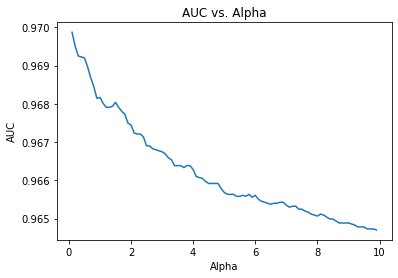

In [8]:
res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [9]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
public_test = pd.read_csv('../../private_test.csv')

In [13]:
public_test["article"] = public_test["title"] + " " + public_test["article"]
public_test = public_test.drop(["title"], axis =1)

In [14]:
public_test_lemmatized = public_test[['article', 'label']].copy()
public_test_lemmatized["article"] = public_test_lemmatized["article"].apply(lemmatize)
public_test_lemmatized = public_test_lemmatized.reset_index()
public_test_lemmatized = public_test_lemmatized.drop(['index'], axis=1)
public_test_lemmatized



,article,label
0,miroslava breach murder mexico jails man order...,1
1,riga regional court sentence oderovs year mont...,1
2,new york charge mallinckrodt insurance fraud r...,1
3,exyahoo ceo scott thompson seven case resume f...,1
4,marc andreessen carl icahn kill entire airline...,1
...,...,...
154,brazilian stateowne bank fund documentary ethe...,0
155,reuven rivlin reuven rivlin israeli politician...,0
156,india general china large conflict not discoun...,0
157,domestic terror law quash political dissent pr...,0


In [15]:
tfidf_public_test = ngram_vectorizer.transform(public_test_lemmatized.article)

public_test_preds_nb = nb_model.predict(tfidf_public_test)

public_test_accuracy_nb = accuracy_score(public_test.label, public_test_preds_nb)

public_test_f1_score_nb = f1_score(public_test.label, public_test_preds_nb)


print('Prediction accuracy for naive bayes model on public test data:', round(public_test_accuracy_nb*100, 3))

print()

print('F1 score for naive bayes model on public test data:', round(public_test_f1_score_nb*100, 3))

Prediction accuracy for naive bayes model on public test data: 89.308

F1 score for naive bayes model on public test data: 91.282


In [16]:
public_test_f1_score_nb

0.9128205128205128

In [46]:


Using Karl's cleaning and lemmatization, title added to article:

Prediction accuracy for naive bayes model on public test data: 90.566

F1 score for naive bayes model on public test data: 92.537


Original cleaned_lemmatized_text.csv for train and lemmatize func is :
Prediction accuracy for naive bayes model on public test data: 91.824

F1 score for naive bayes model on public test data: 93.467

In [65]:
tfidf_public_test = ngram_vectorizer.transform(public_test_lemmatized.article)

public_test_preds_nb = nb_model.predict(tfidf_public_test)

public_test_accuracy_nb = accuracy_score(public_test.label, public_test_preds_nb)

public_test_f1_score_nb = f1_score(public_test.label, public_test_preds_nb)


print('Prediction accuracy for naive bayes model on public test data:', round(public_test_accuracy_nb*100, 3))

print()

print('F1 score for naive bayes model on public test data:', round(public_test_f1_score_nb*100, 3))

Prediction accuracy for naive bayes model on public test data: 91.824

F1 score for naive bayes model on public test data: 93.333




Using Karl's cleaning and lemmatization, title added to article:

Prediction accuracy for naive bayes model on public test data: 90.566

F1 score for naive bayes model on public test data: 92.537


Original cleaned_lemmatized_text.csv for train and lemmatize func is :
Prediction accuracy for naive bayes model on public test data: 91.824

F1 score for naive bayes model on public test data: 93.467